In [0]:
import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models

import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm # progress bar

import itertools
import matplotlib.pyplot as plt


# mount google drive locally
from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/My Drive/AAIIS Project/data/')

# mount google drive locally
#from google.colab import drive
#drive.mount('/content/gdrive')

#os.chdir('/content/gdrive/My Drive/AAIIS Project/data/')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
class detection(nn.Module):
  def __init__(self):
    super(detection, self).__init__()
    self.conv_rpn = nn.Conv2d(512, 512, kernel_size=(3,3), stride=(1,1), padding=1, bias=True)
    self.conv_label = nn.Conv2d(512, 24, kernel_size=(1,1), stride=(1,1), padding=0)
    self.conv_loc = nn.Conv2d(512, 36, kernel_size=(1,1), stride=(1,1), padding=0)
    self.vgg = models.vgg16(pretrained=True)
    self.vgg = self.vgg.features[:24]
  def cuda(self, device=None):
    self = super().cuda(device)
    self.vgg = self.vgg.cuda(device)
    return self 
  def forward(self, x):
    fm = self.vgg(x)
    fm = self.conv_rpn(fm)
    labels = self.conv_label(fm)
    locs = self.conv_loc(fm)
    return labels, locs

In [0]:
def generate_anchors(scale, ratio, h, w):
  anchors = np.empty((h, w, len(scale)*len(ratio), 4), dtype=np.float32)
  for i in range(h):
    for j in range(w):
       for k, sr in enumerate(itertools.product(scale, ratio)):
          ht = sr[0] * np.sqrt(sr[1])
          wt = sr[0] * np.sqrt(1./ sr[1])
          anchors[i, j, k, 0] = ((i*16)+8) - ht/2
          anchors[i, j, k, 1] = ((j*16)+8) - wt/2
          anchors[i, j, k, 2] = ((i*16)+8) + ht/2
          anchors[i, j, k, 3] = ((j*16)+8) + wt/2
  return anchors

In [0]:
def get_iou(anchors, bbox, h, w, scale, ratio):
  iou = np.empty((h, w, len(scale)*len(ratio)), dtype=np.float32)
  max_iou_gt_anchors = np.empty((h, w, len(scale)*len(ratio), 4), dtype=np.float32)
#   for i in range(h):
#     for j in range(w):
#       for k in range(len(scale)*len(ratio)):
#         for bb_min_y, bb_min_x, bb_max_y, bb_max_x in bbox:
          
#           #find area of anchorbox
#           min_y = anchors[i, j, k, 0]
#           min_x = anchors[i, j, k, 1]
#           max_y = anchors[i, j, k, 2]
#           max_x = anchors[i, j, k, 3]
#           area = (max_y - min_y) * (max_x - min_x)
      
#           #find nearest ground truth box
#           max_iou_gt_anchors[i, j, k, 0] = bb_min_y
#           max_iou_gt_anchors[i, j, k, 1] = bb_min_x
#           max_iou_gt_anchors[i, j, k, 2] = bb_max_y
#           max_iou_gt_anchors[i, j, k, 3] = bb_max_x 
      
#           #find bbox area
#           bbox_area = (bb_max_y - bb_min_y) * (bb_max_x - bb_min_x)
      
#           max_min_y = max([min_y, bb_min_y])
#           min_max_y = min([max_y, bb_max_y])
#           max_min_x = max([min_x, bb_min_x])
#           min_max_x = min([max_x, bb_max_x])
      
#           if (max_min_y < min_max_y) and (max_min_x < min_max_x):
#             iou_area = ( min_max_y - max_min_y ) * ( min_max_x - max_min_x )
#             iou[i, j, k] = iou_area/(area + bbox_area - iou_area)
        
#           else:
#             iou[i, j, k] = 0  
  min_y = anchors[:,:,:,0]
  min_x = anchors[:,:,:,1]
  max_y = anchors[:,:,:,2]
  max_x = anchors[:,:,:,3]
  area = (max_y - min_y) * (max_x - min_x)
  
  for bb_min_y, bb_min_x, bb_max_y, bb_max_x in bbox:
    #find nearest ground truth box
    max_iou_gt_anchors[:, :, :, 0] = bb_min_y
    max_iou_gt_anchors[:, :, :, 1] = bb_min_x
    max_iou_gt_anchors[:, :, :, 2] = bb_max_y
    max_iou_gt_anchors[:, :, :, 3] = bb_max_x
  #bbox_area = (max_iou_gt_anchors[:, :, :, 2] - max_iou_gt_anchors[:, :, :, 0]) * (max_iou_gt_anchors[:, :, :, 3] - max_iou_gt_anchors[:, :, :, 1])
    bbox_area = (bb_max_y - bb_min_y) * (bb_max_x - bb_min_x)
    
    
#     max_min_y = np.maximum([min_y[:,:,:], max_iou_gt_anchors[:, :, :, 0]])
#     min_max_y = np.maximum([max_y[:,:,:], max_iou_gt_anchors[:, :, :, 2]])
#     max_min_x = np.maximum([min_x[:,:,:], max_iou_gt_anchors[:, :, :, 1]])
#     min_max_x = np.maximum([max_x[:,:,:], max_iou_gt_anchors[:, :, :, 3]])
  
    for i in range(h):
      for j in range(w):
        for k in range(len(scale)*len(ratio)):
          max_min_y = max([min_y[i,j,k], bb_min_y])
          min_max_y = min([max_y[i,j,k], bb_max_y])
          max_min_x = max([min_x[i,j,k], bb_min_x])
          min_max_x = min([max_x[i,j,k], bb_max_x])
          if (max_min_y < min_max_y) and (max_min_x < min_max_x):
            iou_area = ( min_max_y - max_min_y ) * ( min_max_x - max_min_x )
            iou[i, j, k] = iou_area/(area[i,j,k] + bbox_area - iou_area)        
          else:
            iou[i, j, k] = 0  
          
  return iou, max_iou_gt_anchors

In [0]:
def sample_iou(iou, sample_size):
  chosen_pos_iou = np.empty((3, sample_size), dtype=int)
  chosen_neg_iou = np.empty((3, sample_size), dtype=int)
  
  try:
    max_iou_index = np.where(iou>0.6)
    min_iou_index = np.where(iou<0.1)
  
    chosen_pos_iou_index = np.random.choice(range(len(max_iou_index[0])), size=sample_size, replace = False)
    chosen_neg_iou_index = np.random.choice(range(len(min_iou_index[0])), size=sample_size, replace = False)
  
    for i in range(len(max_iou_index)):
      chosen_pos_iou[i] = max_iou_index[i][chosen_pos_iou_index]
    for i in range(len(min_iou_index)):
      chosen_neg_iou[i] = min_iou_index[i][chosen_neg_iou_index]
      
    return chosen_pos_iou, chosen_neg_iou
  except:
    print("no, no")
    
    return 'no', 'no'

In [0]:
def assign_labels(chosen_pos_iou, chosen_neg_iou, h, w, scale, ratio):
  anchor_label = np.full((h, w, len(scale)*len(ratio)), -1, dtype=int)
  if type(chosen_pos_iou) != str:
    for i, j, k in chosen_pos_iou.transpose():
      anchor_label[i][j][k] = 1
    #anchor_label[i][j][k][1] = 0
  
    for i, j, k in chosen_neg_iou.transpose():
      anchor_label[i][j][k] = 0
    #anchor_label[i][j][k][1] = 1
    
  return anchor_label

def assign_locs(anchors, max_iou_gt_anchors):

  height = anchors[:, :, :, 2] - anchors[:, :, :, 0]
  width = anchors[:, :, :, 3] - anchors[:, :, :, 1]
  c_y = anchors[:, :, :, 0] + height/2
  c_x = anchors[:, :, :, 1] + width/2

  gt_height = max_iou_gt_anchors[:, :, :, 2] - max_iou_gt_anchors[:, :, :, 0]
  gt_width = max_iou_gt_anchors[:, :, :, 3] - max_iou_gt_anchors[:, :, :, 1]
  gt_c_y = max_iou_gt_anchors[:, :, :, 0] + height/2
  gt_c_x = max_iou_gt_anchors[:, :, :, 1] + width/2

  eps = np.finfo(height.dtype).eps
  height = np.maximum(height, eps)
  width = np.maximum(width, eps)

  dy = (gt_c_y - c_y) / height
  dx = (gt_c_x - c_x) / width
  dh = np.log(gt_height / height)
  dw = np.log(gt_width / width)
  
  anchor_locs = np.dstack((dy, dx, dh, dw))
  
  return anchor_locs

In [0]:
def load_data(paths):
  x = []
  bbox = []
  label = pd.read_csv("trainLabels.csv")
  for img in tqdm(os.listdir(paths)):
    path = os.path.join(paths, img)
    image = cv2.imread(path)
    tmp = label[label["filename"].str.contains(img)]
    x1, y1, w, h = list(tmp["bounding_box"])[0][1:-1].split(',')
    
    x.append(image)
    bbox.append([[int(y1), int(x1), int(y1)+int(h), int(x1)+int(w)]])
    
  return x, bbox

In [0]:
lr = 0.0001
cardetection = detection() # initialize

# convert model parameters to work with gpu
cardetection.cuda()

# cross entropy loss
loss_func1 = nn.CrossEntropyLoss(ignore_index = -1).cuda() # weighted loss for brand

#optimizers
optimizer = optim.Adam(cardetection.parameters(), lr=lr)
#optimizer = optim.RMSprop(carclassification.parameters(), lr = lr)
#optimizer = optim.SGD(carclassification.parameters(), lr = lr, momentum=0.9)

In [0]:
def train(x, bbox):
  scale = [128,256,512]
  ratio = [0.25, 0.5, 0.75, 1]
  
  for i in range(len(x)):
    img = torch.from_numpy(x[i])
    h = int(img.shape[0]/16)
    w = int(img.shape[1]/16)
    
    img = img.reshape(-1, 3, img.shape[0], img.shape[1])
    img = (img/255).type(torch.cuda.FloatTensor)
    
    anchors = generate_anchors(scale= scale, ratio=ratio, h=h, w=w)
    iou, max_gt = get_iou(anchors, bbox[i], h = h, w = w, scale = scale, ratio=ratio)
    p, n = sample_iou(iou, sample_size= 5)
    anchor_labels = assign_labels(p, n, h = h, w = w, scale = scale, ratio=ratio)
    anchor_locs = assign_locs(anchors, max_gt)
    anchor_labels = torch.from_numpy(anchor_labels).type(torch.cuda.LongTensor)
    
    print(i, end =" ")
    
    optimizer.zero_grad()
    label, loc = cardetection.forward(img)
    
    l = label.view(-1,2)

    t = anchor_labels.view(-1)
    
    loss1 = loss_func1(l, t)
    
    loss1.backward()
    optimizer.step()
    
  print('done')
    

In [0]:
x, bbox = load_data('test/')

100%|██████████| 169/169 [00:02<00:00, 82.50it/s]


In [0]:
train(x, bbox)

In [0]:
image = cv2.imread('images/04c725ae-68bd-11e8-8db8-0242ac110002.jpg')
label = pd.read_csv("trainLabels.csv")
tmp = label[label["filename"].str.contains('04c725ae-68bd-11e8-8db8-0242ac110002.jpg')]
x, y, w, h = list(tmp["bounding_box"])[0][1:-1].split(',')
image = cv2.rectangle(image,(int(x),int(y)),(int(w),int(h)),(255,0,0),3)
print(x,y,w,h)

92  271  1178  749


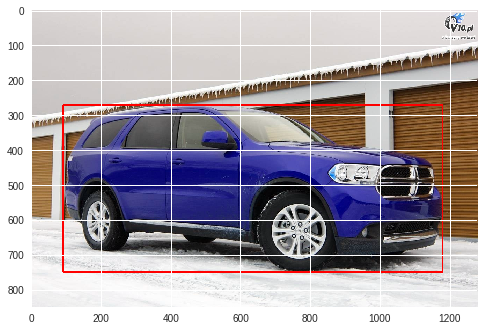

In [0]:
plt.imshow(image)

In [0]:
h=100
w =100
scale=[128, 256, 512]
ratio = [0.5, 1, 2]
#bbox = np.asarray([[300, 400, 428, 528]], dtype=np.float32)
bbox = np.asarray([[250, 150, 500, 500]], dtype=np.float32)


anchors = generate_anchors(scale= scale, ratio=ratio, h=h, w=w)
iou, max_gt = get_iou(anchors, bbox, h = h, w = w, scale = scale, ratio=ratio)
p, n = sample_iou(iou, sample_size= 50)
anchor_labels = assign_labels(p, n, h = h, w = w, scale = scale, ratio=ratio)
anchor_locs = assign_locs(anchors, max_gt)

In [0]:
p

array([[22, 22, 23, 23, 25, 20, 24, 21, 22, 23, 22, 24, 22, 24, 23, 23,
        21, 22, 21, 25, 23, 22, 23, 22, 24, 20, 24, 24, 24, 24, 23, 22,
        21, 25, 22, 25, 23, 23, 22, 24, 24, 23, 22, 22, 23, 24, 26, 25,
        24, 23],
       [19, 18, 23, 21, 21, 19, 18, 20, 19, 18, 22, 18, 21, 21, 22, 18,
        18, 20, 21, 20, 20, 22, 22, 21, 21, 20, 20, 22, 19, 22, 24, 20,
        19, 19, 16, 22, 19, 21, 18, 23, 17, 16, 23, 17, 17, 20, 20, 18,
        19, 19],
       [ 3,  3,  4,  3,  3,  3,  4,  3,  4,  4,  3,  3,  4,  4,  3,  3,
         3,  3,  3,  3,  3,  4,  4,  3,  3,  3,  4,  3,  4,  4,  4,  4,
         3,  3,  4,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  3,  3,  3,
         3,  4]])

In [0]:
iou[22][16][4]

0.6034786

In [0]:
anchor_locs[23][16]

array([-0.89211684, -0.484375  , -0.19605818, -0.19605818,  0.0078125 ,
        0.15197091,  0.15197091,  0.25390625,  0.3259854 , -0.12976694,
       -0.390625  , -0.7595342 ,  0.18511653,  0.0546875 , -0.12976694,
        0.34255823,  0.27734375,  0.18511653,  1.0160046 ,  0.6694307 ,
        0.32285702,  0.32285702, -0.02371653, -0.37029016, -0.37029016,
       -0.7168637 , -1.0634373 ,  0.65932924,  1.0059029 ,  1.3524766 ,
       -0.03381797,  0.3127557 ,  0.65932924, -0.7269651 , -0.38039148,
       -0.03381797], dtype=float32)